<a href="https://colab.research.google.com/github/LisaATaylor/naip-classify/blob/master/SatelliteImageryClassification_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of satellite imagery tiles by transfer learning.

In [1]:
#save content to google drive to avoid downloading again
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from scipy.io import loadmat
data=loadmat('/content/gdrive/My Drive/Springboard/Data/DeepSat6/sat-6-full.mat')

In [0]:
import numpy as np
import pandas as pd

def fixaxes(inarr): #matlab format has long axis in last position, move to 1st to match tensorflow
  return np.rollaxis(inarr,3,0)

#load ndarrays from mat dictionary
trainX=fixaxes(data['train_x']) 
trainy=data['train_y'].T
testX=fixaxes(data['test_x'])
testy = data['test_y'].T
assert np.all(trainX[0,:10,0,0] == data['train_x'][:10,0,0,0])


In [0]:
# get vector of categories for interpreting outputs
anno=pd.read_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/sat6annotations.csv',header=None)
anno.head()
categories=anno.loc[:,0].to_dict()
ycat=pd.DataFrame(trainy).idxmax(axis=1).map(categories)

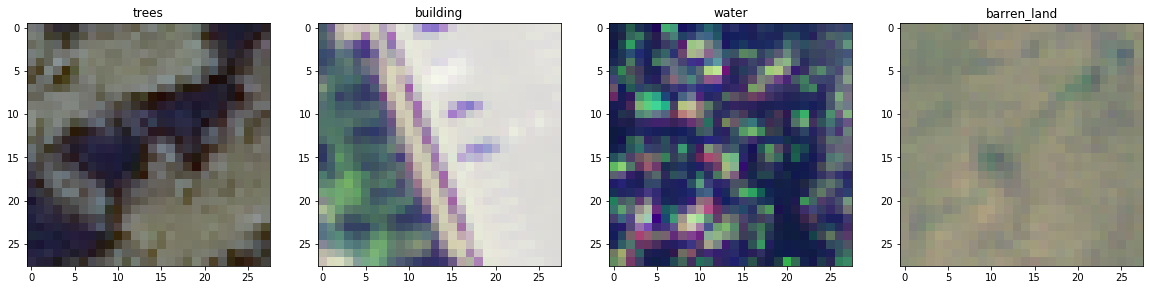

In [5]:
# look at a few tiles, visible bands
import matplotlib.pyplot as plt 
fig,axs=plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(trainX[0,:,:,:3])
axs[1].imshow(trainX[6,:,:,:3])
axs[2].imshow(trainX[2,:,:,:3])
axs[3].imshow(trainX[8,:,:,:3])
axs[0].set_title(ycat.loc[0])
axs[1].set_title(ycat.loc[6])
axs[2].set_title(ycat.loc[2])
axs[3].set_title(ycat.loc[8]);

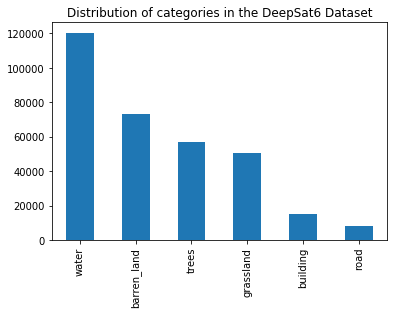

In [6]:
#look at balance between categories:  we see that the categories are not evenly distributed
ycounts=ycat.value_counts()
ycounts.plot.bar()
plt.title('Distribution of categories in the DeepSat6 Dataset');

In [0]:
#get shuffled indices for train-val split
import random
nimg=len(trainX)
ixs=list(range(nimg))
random.shuffle(ixs)
train_ix=ixs[:280000]
val_ix=ixs[280000:]

In [0]:
#create generators to feed imagery to network
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow(trainX[train_ix,:,:,:3],trainy[train_ix],batch_size=512) #puts 280,000 images in train, excludes IR band
val_generator=val_datagen.flow(trainX[val_ix,:,:,:3],trainy[val_ix],batch_size=512) #puts 64,800 records in val

#train_generator=train_datagen.flow(trainX[:280000,:,:,:3],trainy[:280000],batch_size=512) #puts 280,000 images in train, excludes IR band
#val_generator=val_datagen.flow(trainX[280000:,:,:,:3],trainy[280000:],batch_size=512) #puts 64,800 records in val

In [20]:
#Build CNN with transfer learning from VGG16 trained on imagenet
from tensorflow.keras import models,layers
from tensorflow.keras.applications import VGG16

cbase=VGG16(weights='imagenet',include_top=False)#,input_shape=(56,56,3)) 
cbase.trainable=False # freeze convolutional base

tmodel=models.Sequential()
tmodel.add(layers.UpSampling3D((2,2,1),input_shape=(28,28,3))) #upsample so image is bigger than min size for VGG16
tmodel.add(cbase)
tmodel.add(layers.Flatten())

tmodel.add(layers.Dense(512,activation='relu'))
tmodel.add(layers.Dropout(0.5))
tmodel.add(layers.Dense(6,activation='softmax'))
tmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d_2 (UpSampling3 (None, 56, 56, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 3078      
Total params: 14,980,422
Trainable params: 265,734
Non-trainable params: 14,714,688
____________________________________

In [0]:
#Compile model, load
from tensorflow.keras import optimizers
tmodel.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=0.0001),metrics=['accuracy'])

load_weights=False #load weights if not re-fitting
if load_weights:
    tmodel.load_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_baseline.hdf5')

In [22]:
from keras.callbacks import EarlyStopping
early_stop_mon=EarlyStopping(patience=3)
if load_weights!=True:
    history=tmodel.fit_generator(train_generator,steps_per_epoch=545,epochs=30,validation_data=val_generator,validation_steps=20,callbacks=[early_stop_mon])

Epoch 1/30
545/545 [==============================] - 47s 86ms/step - loss: 0.5838 - acc: 0.7724 - val_loss: 0.3233 - val_acc: 0.8669
Epoch 2/30
545/545 [==============================] - 46s 85ms/step - loss: 0.3029 - acc: 0.8779 - val_loss: 0.2437 - val_acc: 0.9003
Epoch 3/30
545/545 [==============================] - 46s 85ms/step - loss: 0.2448 - acc: 0.9052 - val_loss: 0.2062 - val_acc: 0.9195
Epoch 4/30
545/545 [==============================] - 46s 85ms/step - loss: 0.2135 - acc: 0.9195 - val_loss: 0.1842 - val_acc: 0.9291
Epoch 5/30
545/545 [==============================] - 47s 85ms/step - loss: 0.1944 - acc: 0.9275 - val_loss: 0.1675 - val_acc: 0.9389
Epoch 6/30
545/545 [==============================] - 47s 85ms/step - loss: 0.1804 - acc: 0.9334 - val_loss: 0.1569 - val_acc: 0.9432
Epoch 7/30
545/545 [==============================] - 47s 85ms/step - loss: 0.1698 - acc: 0.9368 - val_loss: 0.1476 - val_acc: 0.9460
Epoch 8/30
545/545 [==============================] - 47s 85ms

In [0]:
save_weights=True
if save_weights:
    tmodel.save_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_baseline.hdf5')
    #dump history too
    hist_df=pd.DataFrame.from_dict(history.history)
    hist_df.to_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_history.csv')


In [0]:
#tmodel.load_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_baseline.hdf5')


In [0]:
#hist=pd.read_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_history.csv')

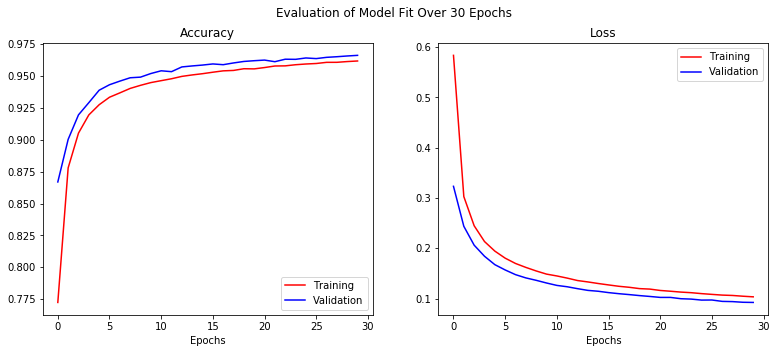

In [26]:
# Plot progression of model fit over each epoch
# adapted from Deep Learning With Python (Chollet)
h=history.history
epochs = range(len(h['acc']))
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(epochs, h['acc'], 'r', label='Training')
ax[0].plot(epochs, h['val_acc'], 'b', label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, h['loss'], 'r', label='Training')
ax[1].plot(epochs, h['val_loss'], 'b', label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of Model Fit Over 30 Epochs');


In [0]:
# Look at predictions on held-out data
testX_rescaled=testX[:,:,:,:3]/255
predy=tmodel.predict(testX_rescaled)

In [0]:
#get pd Series of predicted and actual categories for test dataset
testycat=pd.DataFrame(testy).idxmax(axis=1).map(categories) #actual
testycat_pred=pd.DataFrame(predy).idxmax(axis=1).map(categories) #pred

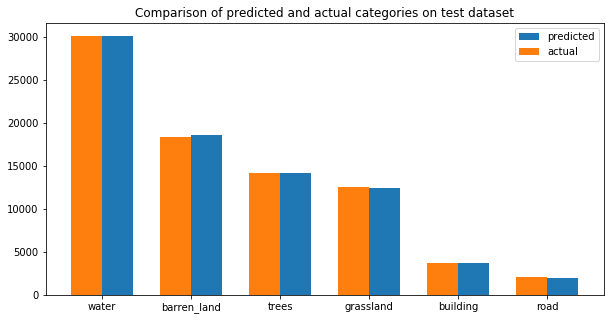

In [29]:
#Plot comparison of pred vs actual on test
pred_df=testycat_pred.value_counts()
act_df=testycat.value_counts()
fig,ax=plt.subplots(figsize=(10,5))
ind=np.arange(6)
width=0.35
pred=ax.bar(ind+width,pred_df.values,width=width,label='predicted')
act=ax.bar(ind,act_df.values,width=width,label='actual')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(pred_df.index)
ax.legend()
ax.set_title('Comparison of predicted and actual categories on test dataset');

In [30]:
#get prediction errors
compare_df=pd.concat([testycat,testycat_pred],axis=1)
compare_df.columns=['actual','predicted']
compare_df=compare_df.assign(mismatch=compare_df.actual!=compare_df.predicted)
compare_df.loc[compare_df.mismatch].head()

,actual,predicted,mismatch
37,barren_land,grassland,True
43,grassland,barren_land,True
84,barren_land,grassland,True
88,grassland,barren_land,True
92,barren_land,grassland,True


In [31]:
#overall total of correct vs incorrect predictions
compare_df['mismatch'].value_counts()

False    78028
True      2972
Name: mismatch, dtype: int64

In [32]:
#accuracy on test dataset
print('Overall accuracy on test dataset: {0:.3f}'.format(1-(compare_df.mismatch.sum()/compare_df.mismatch.count())))

Overall accuracy on test dataset: 0.963


In [33]:
# Look at confusion matrix, classification report
from sklearn.metrics import classification_report,confusion_matrix
print('Classification Report:')
print(classification_report(testycat,testycat_pred))
print('Confusion Matrix:')
print(confusion_matrix(testycat,testycat_pred))
print('\nNumber of Correct Classifications:')
correct=compare_df.loc[~compare_df.mismatch].groupby(['actual','predicted']).count()
correct.columns=['Correct']
print(correct) #check order of entries along diagonal of confusion matrix

Classification Report:
              precision    recall  f1-score   support

 barren_land       0.94      0.95      0.94     18367
    building       0.95      0.96      0.95      3714
   grassland       0.91      0.90      0.91     12596
        road       0.96      0.93      0.94      2070
       trees       0.97      0.97      0.97     14185
       water       1.00      1.00      1.00     30068

    accuracy                           0.96     81000
   macro avg       0.95      0.95      0.95     81000
weighted avg       0.96      0.96      0.96     81000

Confusion Matrix:
[[17417    32   766     6   143     3]
 [   68  3555     4    75     6     6]
 [  983    13 11328     5   266     1]
 [   15   122     7  1920     4     2]
 [   99     6   308     0 13755    17]
 [    0     5     0     0    10 30053]]

Number of Correct Classifications:
                         Correct
actual      predicted           
barren_land barren_land    17417
building    building        3555
grassland   g

In [34]:
# grasslands have slightly lower recall wrt other categories 
gl_mismatch=compare_df.loc[(compare_df.mismatch)&(compare_df.actual=='grassland')]
print(gl_mismatch['predicted'].value_counts()) #roads most often misclassified as buildings
gl_mismatch['ixcopy']=gl_mismatch.index
mismatches=gl_mismatch.groupby('predicted')['ixcopy'].first()

barren_land    983
trees          266
building        13
road             5
water            1
Name: predicted, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


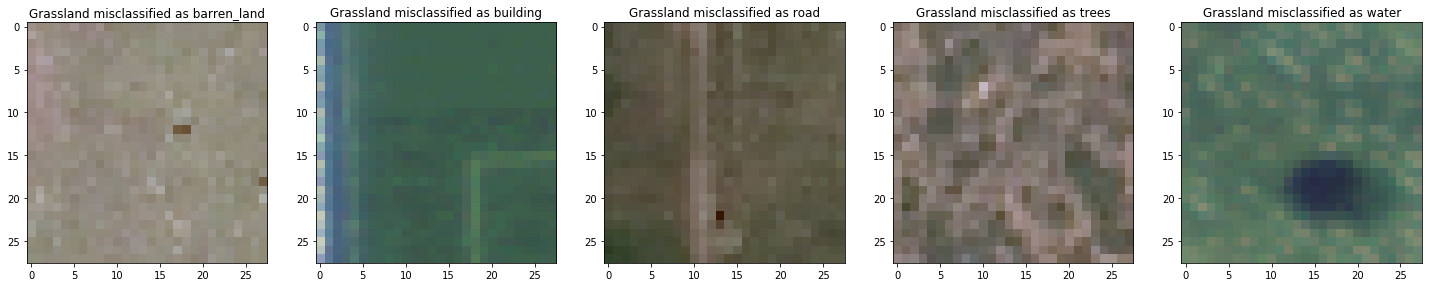

In [35]:
#view some mismatches
fig,axs=plt.subplots(1,5,figsize=(25,10))
axix=0
for i,v in mismatches.iteritems():
  axs[axix].imshow(testX[v,:,:,:3])
  axs[axix].set_title('Grassland misclassified as {}'.format(i))
  axix+=1